# Pathway patterns throughout the day

## Aim

Show key pathway statistics broken down by arrival time of day (which we know in three hour intervals).

Replicates SAMueL-1 analysis [available to view here](https://samuel-book.github.io/samuel-1/descriptive_stats/02a_daily_patterns.html).

## Set up

In [1]:
# Import packages and functions
import collections
from dataclasses import dataclass
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from math import ceil

# Set max rows when display dataframe
pd.set_option('display.max_rows', 100)

# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    admission_only_filename = 'reformatted_data_admissions_only.csv'


paths = Paths()

In [3]:
# Load data
data = pd.read_csv(os.path.join(paths.data_path,
                                paths.data_filename))
data_full = pd.read_csv(os.path.join(paths.data_path,
                                     paths.admission_only_filename))

## Reformat data

Add extra columns for analysis.

In [4]:
# Group by whether aged 80 or older
data_full['age_80_plus'] = np.where(data_full['age'] >= 80, 1, 0)

# Group by whether known onset to arrival time is 4 hours or less
data_full['arrive_4h_known'] = np.where(
    (data_full['onset_to_arrival_time'] <= 240) &
    (data_full['onset_known'] == 1), 1, 0)

# Group by whether scanned within 4 hours
data['arrival_to_scan_4h'] = np.where(
    data['arrival_to_scan_time'] <= 240, 1, 0)

# Add arrival to thrombolysis and onset to thrombolysis
data['arrival_to_thrombolysis'] = (
    data['arrival_to_scan_time'] + data['scan_to_thrombolysis_time'])
data['onset_to_thrombolysis'] = (
    data['onset_to_arrival_time'] + data['arrival_to_thrombolysis'])

# Create dataset of just those scanned within 4 hours
data_scan4h = data[data['arrival_to_scan_time'] <= 240]

## Summarise key pathway metrics by time of day

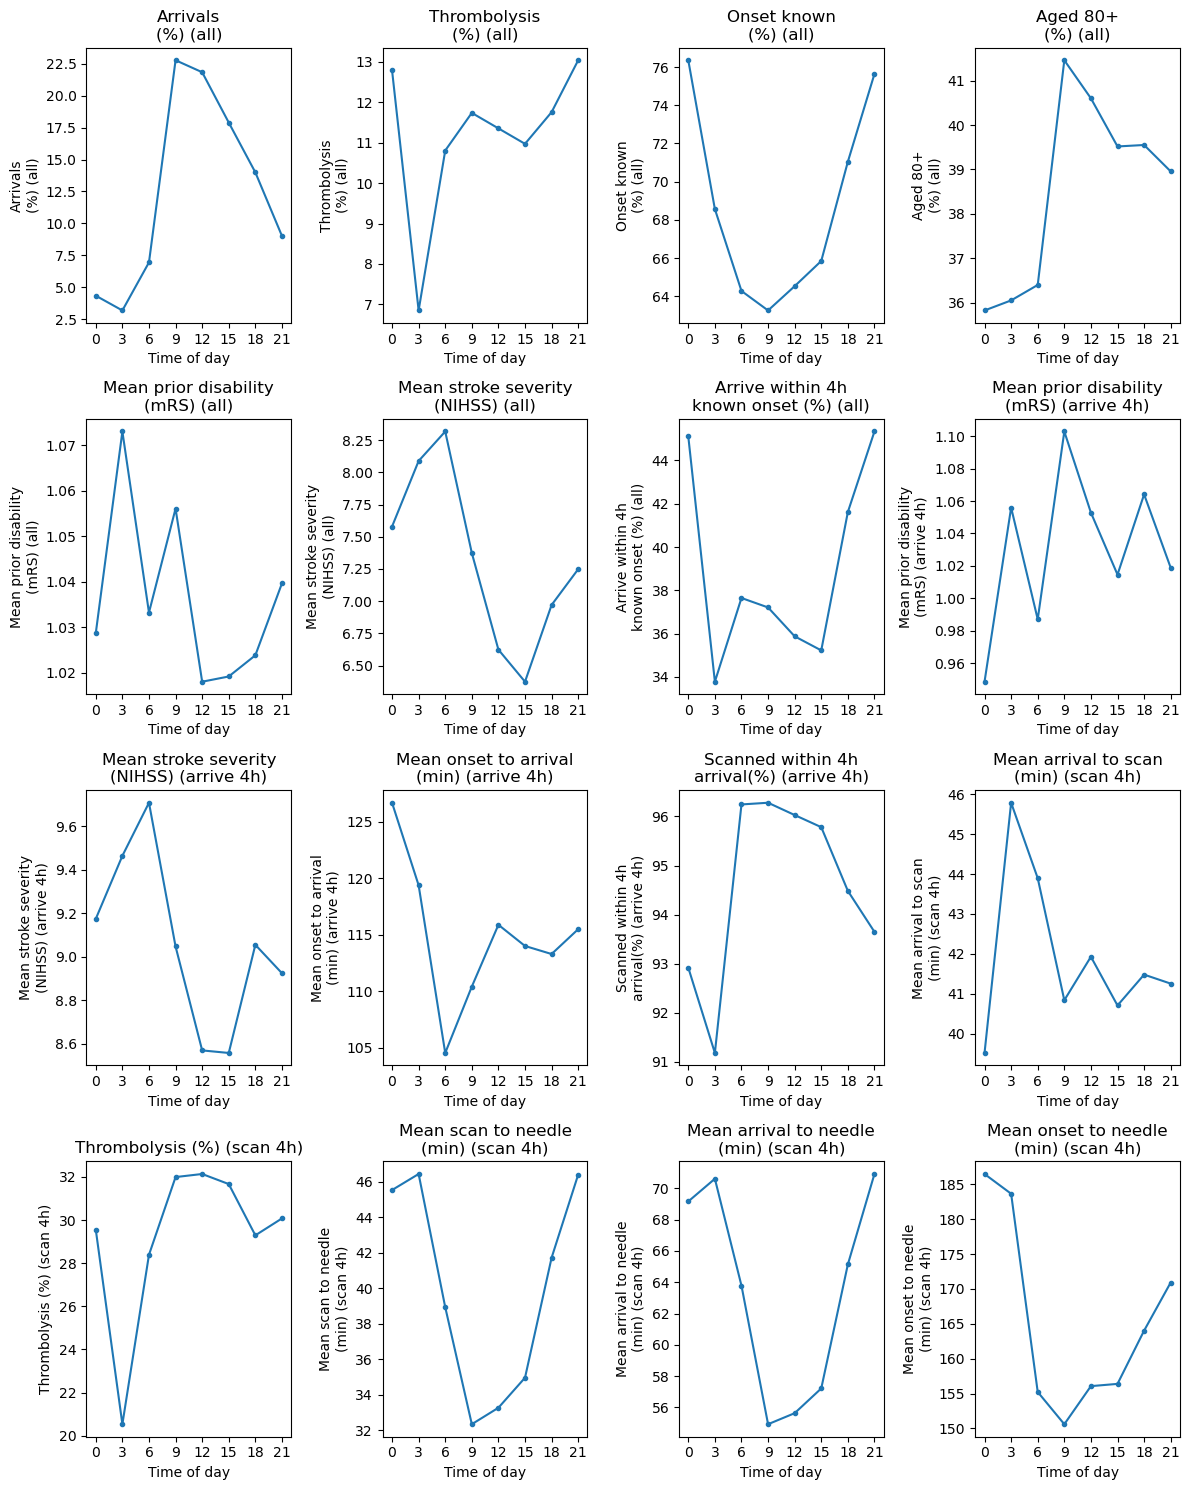

In [5]:
# Define columns of interest and appropriate labels
# (all) and (4h) is used to indicate which dataset to use
pathway_col = {
    'Arrivals\n(%) (all)': 'arrivals',
    'Thrombolysis\n(%) (all)': 'thrombolysis',
    'Onset known\n(%) (all)': 'onset_known',
    'Aged 80+\n(%) (all)': 'age_80_plus',
    'Mean prior disability\n(mRS) (all)': 'prior_disability',
    'Mean stroke severity\n(NIHSS) (all)': 'stroke_severity',
    'Arrive within 4h\nknown onset (%) (all)': 'arrive_4h_known',
    'Mean prior disability\n(mRS) (arrive 4h)': 'prior_disability',
    'Mean stroke severity\n(NIHSS) (arrive 4h)': 'stroke_severity',
    'Mean onset to arrival\n(min) (arrive 4h)': 'onset_to_arrival_time',
    'Scanned within 4h\narrival(%) (arrive 4h)': 'arrival_to_scan_4h',
    'Mean arrival to scan\n(min) (scan 4h)': 'arrival_to_scan_time',
    'Thrombolysis (%) (scan 4h)': 'thrombolysis',
    'Mean scan to needle\n(min) (scan 4h)': 'scan_to_thrombolysis_time',
    'Mean arrival to needle\n(min) (scan 4h)': 'arrival_to_thrombolysis',
    'Mean onset to needle\n(min) (scan 4h)': 'onset_to_thrombolysis'
}

# Create subplots, with number of rows from number of variables
columns = 4
rows = ceil(len(pathway_col)/columns)
fig, ax = plt.subplots(rows, columns, figsize=(12, 15))

# Convert keys and values into arrays
keys = [k for k in pathway_col.keys()]
values = [v for v in pathway_col.values()]

# Create plots
x = 0
for r in range(rows):
    for c in range(columns):
        # Stops loop (so will leave empty plots)
        if len(pathway_col) == x:
            break
        else:
            # Extract relevant column and label from dictionary
            label = keys[x]
            col = values[x]

            # Reset res (so doesn't plot in case of dataset error)
            res = 0

            if col == 'arrivals':
                # Count number of rows
                res = (data_full.groupby('arrival_time_3_hour_period').size() /
                       len(data_full.index))
            else:
                # Find mean, grouped by arrival time window
                if '(all)' in label:
                    res = (data_full
                           .groupby('arrival_time_3_hour_period')[col]
                           .mean())
                elif '(arrive 4h)' in label:
                    res = (data
                           .groupby('arrival_time_3_hour_period')[col]
                           .mean())
                elif '(scan 4h)' in label:
                    res = (data_scan4h
                           .groupby('arrival_time_3_hour_period')[col]
                           .mean())
                else:
                    print('Error - dataset not one of the options')

            # If its marked as percentage, multiply by 100
            if '%' in label:
                res = res*100

            # Plot those results
            res.plot(marker='.', ax=ax[r, c])
            ax[r, c].set_xticks(res.index)
            ax[r, c].set_xlabel('Time of day')
            ax[r, c].set_ylabel(label)
            ax[r, c].set_title(label)

            # Increment counter
            x += 1

# Display plot
plt.tight_layout()
plt.show()

Observations - same as in SAMueL-1:
* Arrivals peak between 9am and 3pm, and then drop steadily to a low between 3am and 6pm.
* Thrombolysis use is significantly lower in the 3am to 6am epoch, but only 3% of admissions occur in this period.
* Arrival-to-scan time is higher 3am to 9am, but reasonably stable for the rest oif the day.
* Scan-to-needle is approximately 10 minutes slower at night (9pm to 9am) than during the day (9am to 9pm).
* The lowest proportion of arrivals with known stroke onset occurs during the day (6am to 6pm).